In [5]:

import pandas
import os
from metric_utils import *
import torch
import ast
import numpy as np
from swarm_visualizer.boxplot import  plot_paired_boxplot
from swarm_visualizer.utility.general_utils import save_fig, set_plot_properties
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
from seaborn import lineplot,scatterplot
warnings.filterwarnings('ignore')
from prettytable import PrettyTable
import plotly.express as px


## Load the data

In [4]:
# Training Distribution Plots

TRAIN_FILENAME = '../../bdd100k/metadata_seg.csv'
TEST_FILENAME = '../../bdd100k/metadata_val_seg.csv'

train_df = pandas.read_csv(TRAIN_FILENAME)
plt.figure(figsize=(10, 10))
df = train_df.groupby('condition').size()/train_df.shape[0]
print(df)
df.plot(kind='bar')

plt.xlabel('Condition')
plt.ylabel('Number of Samples')
plt.title('Training Distribution')
plt.figure(figsize=(10, 10))
val_df = pandas.read_csv(TEST_FILENAME)
df = val_df.groupby('condition').size()/val_df.shape[0]
print(df)
df.plot(kind='bar')
plt.xlabel('Condition')
plt.ylabel('Number of Samples')


FileNotFoundError: [Errno 2] No such file or directory: '../../bdd100k/metadata_seg.csv'

condition
Clear, Dawn/Dusk     0.109890
Clear, Day           0.112880
Clear, Night         0.110289
Cloudy, Dawn/Dusk    0.112307
Cloudy, Day          0.110364
Cloudy, Night        0.108071
Rainy, Dawn/Dusk     0.111609
Rainy, Day           0.112631
Rainy, Night         0.111958
dtype: float64


<Figure size 1000x1000 with 0 Axes>

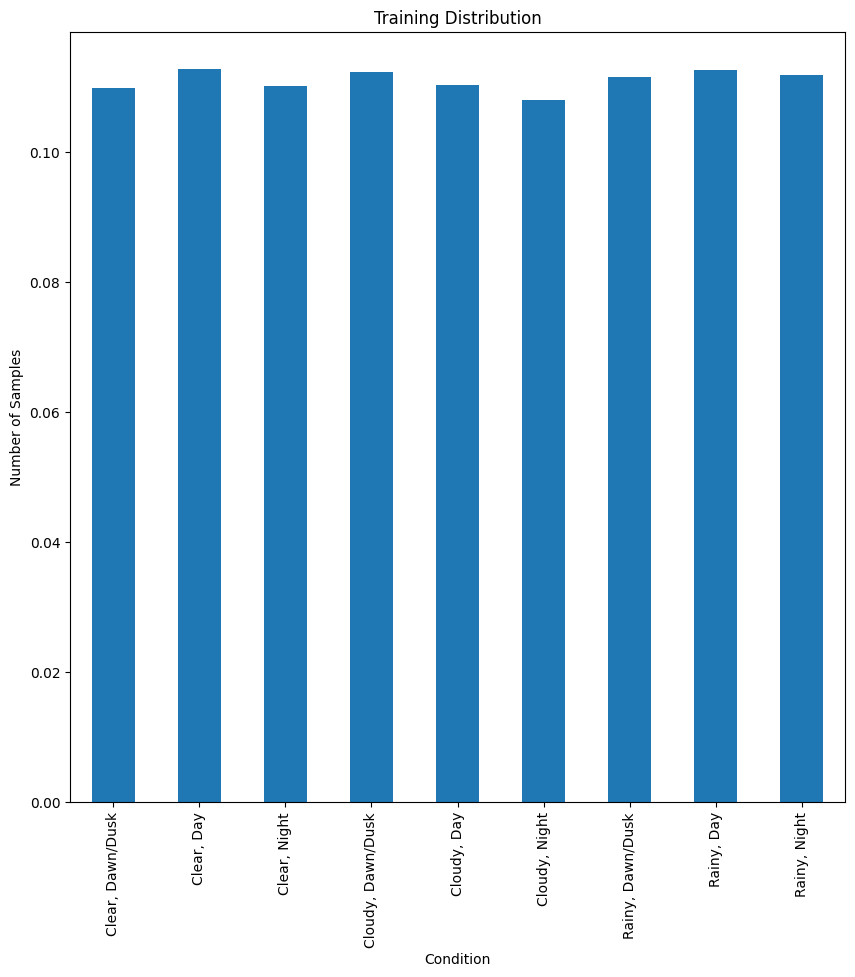

<Figure size 1000x1000 with 0 Axes>

In [7]:
# Synthetic Training Distribution Plots

TRAIN_FILENAME = '/store/harsh/data/waymo_synthetic_ft/metadata_seg.csv'

train_df = pandas.read_csv(TRAIN_FILENAME)
plt.figure(figsize=(10, 10))
df = train_df.groupby('condition').size()/train_df.shape[0]
print(df)
df.plot(kind='bar')

plt.xlabel('Condition')
plt.ylabel('Number of Samples')
plt.title('Training Distribution')
plt.figure(figsize=(10, 10))


In [12]:
FOLDER = '../tests/'
files = os.listdir(FOLDER)
PALLETE = {
            "undefined": [0, 0, 0],
            "road": [128, 64, 128],
            "sidewalk": [244, 35, 232],
            "building": [70, 70, 70],
            "wall": [190, 153, 153],
            "fence": [102, 102, 156],
            "pole": [153, 153, 153],
            "traffic light": [250, 170, 30],
            "traffic sign": [220, 220, 0],
            "vegetation": [107, 142, 35],
            "terrain": [152, 251, 152],
            "sky": [70, 130, 180],
            "person": [220, 20, 60],
            "rider": [255, 0, 0],
            "car": [0, 0, 142],
            "truck": [0, 0, 70],
            "bus": [0, 60, 100],
            "train": [0, 80, 100],
            "motorcycle": [0, 0, 230],
            "bicycle": [119, 11, 32]
        }
CLASSES = np.array(list(PALLETE.keys()))
COMPUTE_CLASSES = np.arange(len(CLASSES))[1:]
print(CLASSES[COMPUTE_CLASSES])


['road' 'sidewalk' 'building' 'wall' 'fence' 'pole' 'traffic light'
 'traffic sign' 'vegetation' 'terrain' 'sky' 'person' 'rider' 'car'
 'truck' 'bus' 'train' 'motorcycle' 'bicycle']


## Compile Data

mask2former_r50_8xb2-90k_bdd-512x512
segformer_mit-b3_8xb2-160k_mixedbdd-512x512
mask2former_swin-t_8xb2-160k_mixedbdd-512x512
segformer_mit-b3_8xb2-160k_mixedbddft-512x512
mask2former_r50_8xb2-90k_mixedbdd-512x512
segformer_mit-b3_8xb2-160k_bdd-512x512
mask2former_swin-t_8xb2-160k_mixedbddft-512x512
mask2former_swin-t_8xb2-160k_bdd-512x512


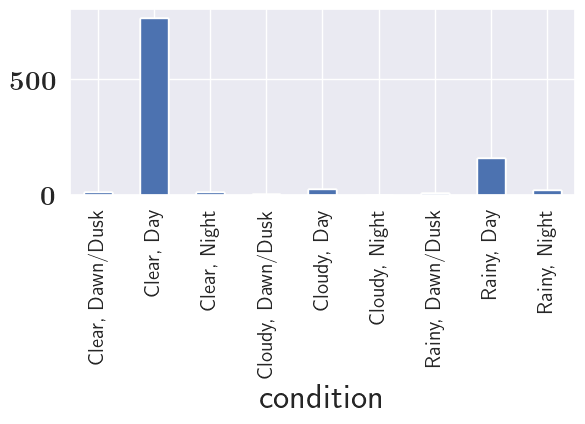

In [13]:
MODEL_DATA= dict()
for file in files:
    if file.endswith('.csv') and 'bdd' in file:
        model = file.split('.')[0]
        df = pandas.read_csv(FOLDER + file)
        # Convert each relevant column to a Torch tensor
        MODEL_DATA[model] = df
        # print(len(df))
        # print(df.groupby('condition').size())
        # barplot
        print(model)
        df.groupby('condition').size().plot(kind='bar')
    
def string_to_tensor(tensor_string):
    # Convert string representation of a tensor to an actual tensor
    # Use ast.literal_eval to safely evaluate the string
    #print(tensor_string.strip("[]").split())
    array_list = [float(item) for item in tensor_string.strip("[]").split()]

    # Convert the list to a NumPy array
    np_array = np.array(array_list)

    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array)
    return tensor

def stack_sum_tensors(series):
    return torch.stack(series, dim=0).sum(dim=0).detach().cpu().numpy()

def mean_metrics(series, class_idx):
    #ignore nans when computing the mean
    
    series[np.isinf(series)] = np.nan
    #print(series[class_idx])
    return np.nanmean(series[class_idx]).item()

def std_metrics(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    return np.nanstd(series[class_idx]).item()

def accumulate(series):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    #print(series)
    #Only return the series for class_idx and non nan values
    return series.tolist()

def per_class_metrics(df_dict):
    
    # convert data frame to dictionary where keys are the metrics and the values are a list
    # of numbers corresponding to the performance of each class
    
    #df_dict = df.to_dict(orient='list')
    # For each class compute log the mean metrics
    ret_metrics_class = OrderedDict({
        ret_metric: np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in df_dict.items()
    })
    
    class_table_data = PrettyTable()


    ret_metrics_class.update({'Class': CLASSES})
    ret_metrics_class.move_to_end('Class', last=False)

    for key, val in ret_metrics_class.items():
        class_table_data.add_column(key, val)

    print('per class results:\n')
    print('\n' + class_table_data.get_string())

In [14]:
warnings.filterwarnings('always')
avg_metrics_df = pandas.DataFrame(columns=['model','condition', 'accuracy', 'IoU', 'Dice', 'F1'])
avg_metrics_df['model'] = MODEL_DATA.keys()
tensor_columns = ['mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'] 
metrics_column = ['accuracy', 'IoU', 'Dice', 'F1']
avg_metrics_col = ['mAcc','mIoU', 'mDice', 'mF1']

data_plot = dict()
avg_data_plot = dict()
for model, data in MODEL_DATA.items():
    print('RESULTS FOR MODEL: ', model)
    metrics_df = pandas.DataFrame(columns=['condition', 'accuracy', 'IoU', 'Dice', 'F1'])
    # List of tensor columns

    # Convert tensor columns from string to actual tensors
    for col in tensor_columns:
        data[col] = data[col].apply(string_to_tensor)
    
    # Compute mIoU, mAcc, mDice, mF1 across all conditions
    data_avg_all = dict(
        mIoU_intersect=[],
        mIoU_union=[],
        mIoU_pred_label=[],
        mIoU_label=[]
    )
    data_avg_all['mIoU_intersect'] = torch.stack(list(data['mIoU_intersect'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_union'] = torch.stack(list(data['mIoU_union'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_pred_label'] = torch.stack(list(data['mIoU_pred_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_label'] = torch.stack(list(data['mIoU_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
        # Pretty Table for per class metrics

    
    # for key, value in data_avg_all.items():
    #     print(data_avg_all[key].shape)
    #     print(data_avg_all[key])
    
    compiled_metrics = dict()
    
    compiled_metrics['mIoU'] = IoU = compute_IOU(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    compiled_metrics['mAcc'] = accuracy = compute_accuracy(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_label'])
    compiled_metrics['mDice'] = Dice = compute_DICE(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    compiled_metrics['mF1'] = f1score = compute_F1(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_pred_label'], data_avg_all['mIoU_label'])
    
    per_class_metrics(compiled_metrics)
    
    print('mIoU: ', np.nanmean(IoU).item())
    print('mAcc: ', np.nanmean(accuracy).item())
    print('mDice: ', np.nanmean(Dice).item())
    print('mF1: ', np.nanmean(f1score).item())
    
    
    grouped_data = data.groupby('condition')[tensor_columns]
    grouped_data = grouped_data.agg(list)
    num_items = grouped_data.applymap(len)
    grouped_sum = grouped_data.applymap(stack_sum_tensors)
    
    grouped_sum['accuracy'] = compute_accuracy(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_label'])
    grouped_sum['IoU'] = compute_IOU(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['Dice'] = compute_DICE(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['F1'] = compute_F1(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_pred_label'], grouped_sum['mIoU_label'])
    metrics_df = grouped_sum[metrics_column]
    
    metrics_df_post = metrics_df.copy()
    metrics_df_post['accuracy']= metrics_df['accuracy'].apply(accumulate)
    metrics_df_post['IoU'] = metrics_df['IoU'].apply(accumulate)
    metrics_df_post['Dice']= metrics_df['Dice'].apply(accumulate)
    metrics_df_post['F1']= metrics_df['F1'].apply(accumulate)
    data_plot[model] = metrics_df_post
    

    
    # Compute mean and std across all conditions
    metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mDice'] = metrics_df['Dice'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mF1'] = metrics_df['F1'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdAcc'] = metrics_df['accuracy'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdIoU'] = metrics_df['IoU'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdDice'] = metrics_df['Dice'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdF1'] = metrics_df['F1'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    avg_metrics_df = metrics_df[avg_metrics_col]
    avg_data_plot[model] = avg_metrics_df.copy()
    #print(avg_metrics_df)




RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_bdd-512x512
per class results:


+---------------+-------+-------+-------+-------+
|     Class     |  mIoU |  mAcc | mDice |  mF1  |
+---------------+-------+-------+-------+-------+
|   undefined   | 61.84 |  86.6 | 76.42 | 76.42 |
|      road     | 89.08 | 92.84 | 94.23 | 94.23 |
|    sidewalk   | 59.02 | 69.96 | 74.23 | 74.23 |
|    building   | 77.74 | 83.99 | 87.48 | 87.48 |
|      wall     |  8.72 |  10.2 | 16.04 | 16.04 |
|     fence     | 26.87 | 37.32 | 42.36 | 42.36 |
|      pole     | 41.24 | 53.88 |  58.4 |  58.4 |
| traffic light | 50.28 | 67.07 | 66.91 | 66.91 |
|  traffic sign | 36.39 | 60.87 | 53.36 | 53.36 |
|   vegetation  | 83.64 | 90.45 | 91.09 | 91.09 |
|    terrain    | 43.52 | 58.17 | 60.65 | 60.65 |
|      sky      | 92.02 |  94.2 | 95.84 | 95.84 |
|     person    | 59.32 | 71.73 | 74.46 | 74.46 |
|     rider     | 32.66 | 43.29 | 49.24 | 49.24 |
|      car      | 87.54 | 94.17 | 93.36 | 93.36 |
|     truck     | 41.2

/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_2044394/1958103786.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2044394/1958103786.py:74: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2044394/1958103786.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

per class results:


+---------------+-------+-------+-------+-------+
|     Class     |  mIoU |  mAcc | mDice |  mF1  |
+---------------+-------+-------+-------+-------+
|   undefined   | 72.91 | 82.02 | 84.33 | 84.33 |
|      road     | 90.89 | 96.02 | 95.23 | 95.23 |
|    sidewalk   | 59.64 | 74.52 | 74.72 | 74.72 |
|    building   | 81.22 | 92.03 | 89.64 | 89.64 |
|      wall     | 31.21 | 44.03 | 47.58 | 47.58 |
|     fence     | 43.28 |  61.9 | 60.41 | 60.41 |
|      pole     | 31.72 | 38.28 | 48.16 | 48.16 |
| traffic light | 40.07 | 48.99 | 57.21 | 57.21 |
|  traffic sign | 33.24 | 45.61 |  49.9 |  49.9 |
|   vegetation  | 84.09 | 91.89 | 91.36 | 91.36 |
|    terrain    | 47.38 | 63.16 |  64.3 |  64.3 |
|      sky      | 93.78 | 96.42 | 96.79 | 96.79 |
|     person    | 55.54 |  67.3 | 71.42 | 71.42 |
|     rider     | 18.61 | 20.82 | 31.38 | 31.38 |
|      car      | 88.03 | 95.17 | 93.64 | 93.64 |
|     truck     | 54.69 |  65.8 | 70.71 | 70.71 |
|      bus      | 80.66 | 89.

/tmp/ipykernel_2044394/1958103786.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2044394/1958103786.py:74: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2044394/1958103786.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/h

RESULTS FOR MODEL:  segformer_mit-b3_8xb2-160k_bdd-512x512
per class results:


+---------------+-------+-------+-------+-------+
|     Class     |  mIoU |  mAcc | mDice |  mF1  |
+---------------+-------+-------+-------+-------+
|   undefined   |  72.9 |  82.0 | 84.33 | 84.33 |
|      road     | 90.59 | 94.84 | 95.06 | 95.06 |
|    sidewalk   | 56.59 | 77.23 | 72.28 | 72.28 |
|    building   | 81.19 | 91.05 | 89.62 | 89.62 |
|      wall     |  31.1 |  42.2 | 47.45 | 47.45 |
|     fence     | 44.37 |  62.7 | 61.47 | 61.47 |
|      pole     | 31.79 | 39.27 | 48.24 | 48.24 |
| traffic light | 41.19 | 53.15 | 58.35 | 58.35 |
|  traffic sign | 35.03 | 47.87 | 51.88 | 51.88 |
|   vegetation  | 83.85 | 92.63 | 91.22 | 91.22 |
|    terrain    | 45.02 | 64.14 | 62.09 | 62.09 |
|      sky      | 94.43 | 96.85 | 97.13 | 97.13 |
|     person    | 53.65 |  71.3 | 69.83 | 69.83 |
|     rider     | 13.39 | 14.64 | 23.62 | 23.62 |
|      car      | 88.04 | 94.92 | 93.64 | 93.64 |
|     truck     | 53

/tmp/ipykernel_2044394/1958103786.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2044394/1958103786.py:74: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2044394/1958103786.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/h

## Plot performance of original models


In [15]:
 # Formatting data plot items
original_data_plot = {}
for model, data_ in data_plot.items():
    print(model)
    if 'synth' not in model and 'mixed' not in model:
        data=data_.copy()
        data['model'] = model
        
        if 'mask2former_swin' in model:
            data['model_cat'] = 'Mask2Former Swin-T' 
        elif 'mask2former_r50' in model:
            data['model_cat'] = 'Mask2Former Resnet 50' 
        elif 'segformer' in model:
            data['model_cat'] = 'Segformer'
        # print(data.columns)
        # print(data.index)
        data.reset_index(inplace=True)
        print(data.index)
        print(data.columns)
        data['accuracy'] = data['accuracy'].apply(np.nanmean)
        data['IoU'] = data['IoU'].apply(np.nanmean)
        data['Dice'] = data['Dice'].apply(np.nanmean)
        data['F1'] = data['F1'].apply(np.nanmean)
        original_data_plot[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original = pd.concat([dfs for dfs in original_data_plot.values()], ignore_index=True)

mask2former_r50_8xb2-90k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_mixedbdd-512x512
mask2former_swin-t_8xb2-160k_mixedbdd-512x512
segformer_mit-b3_8xb2-160k_mixedbddft-512x512
mask2former_r50_8xb2-90k_mixedbdd-512x512
segformer_mit-b3_8xb2-160k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
mask2former_swin-t_8xb2-160k_mixedbddft-512x512
mask2former_swin-t_8xb2-160k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')


/tmp/ipykernel_2044394/3899876757.py:13: UserWarning:

The palette list has more values (10) than needed (3), which may not be intended.



Text(0.5, 0, 'Conditions')

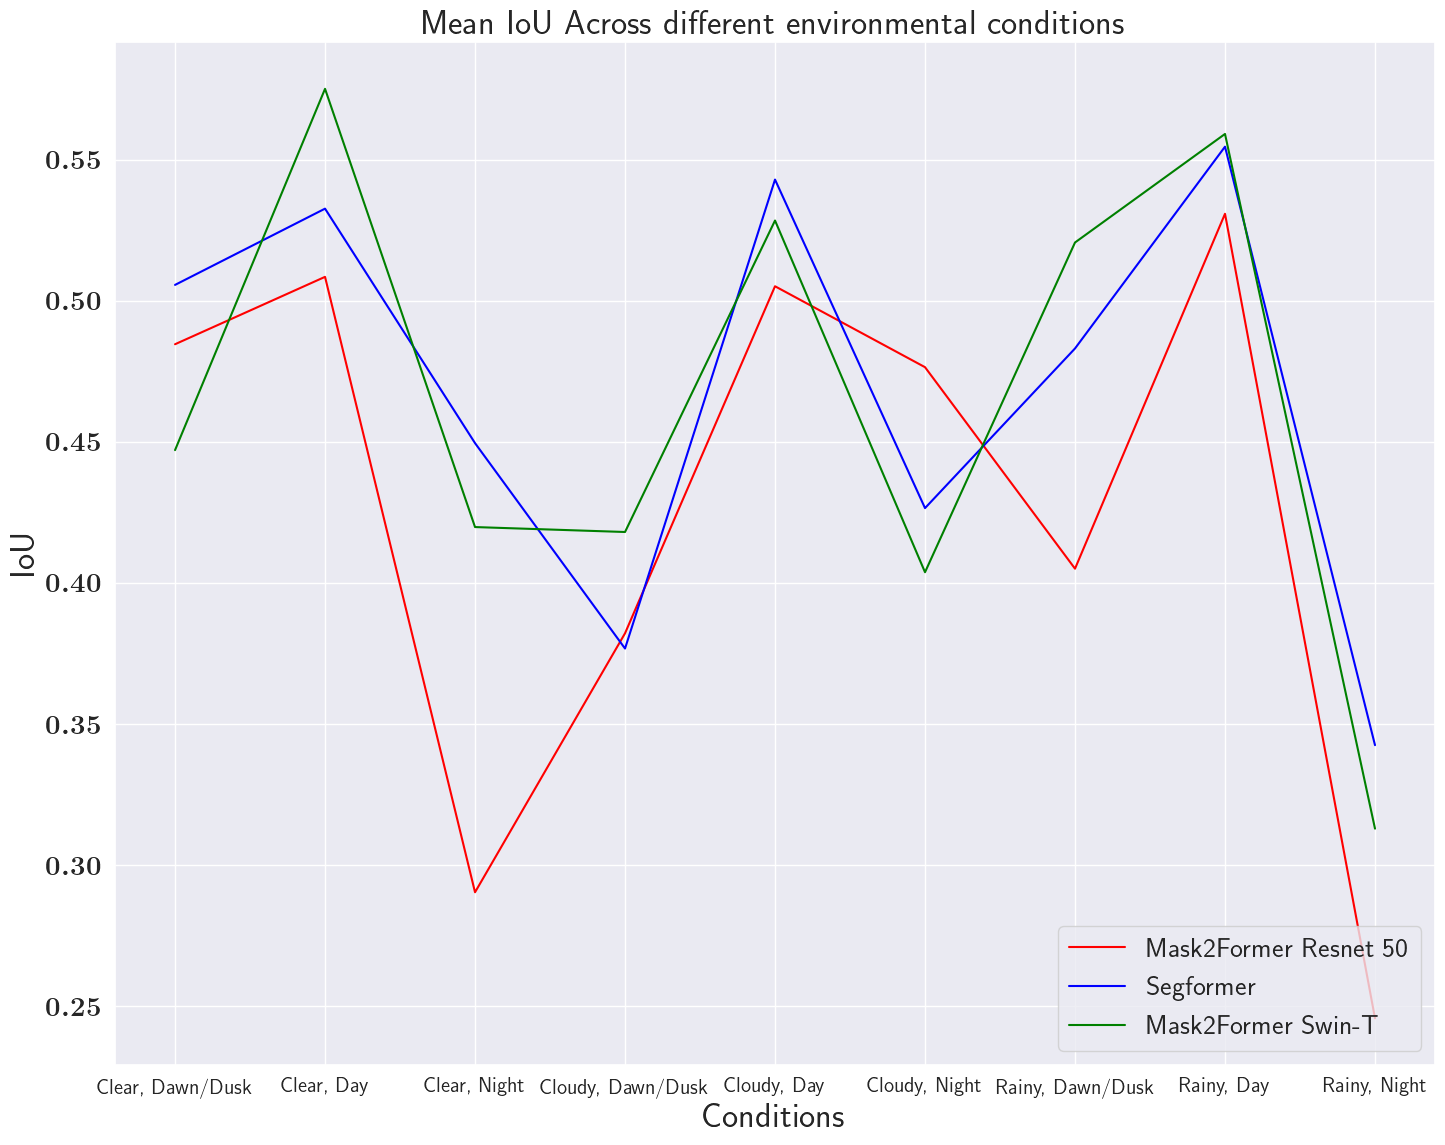

In [16]:
# Line plot of accuracy with respect to conditions
set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 15,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))

lineplot(all_data_original,
                    x='condition',
                    y='IoU', 
                    hue='model_cat', 
                    palette=pallete,
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('Mean IoU Across different environmental conditions', fontsize=25)
plt.ylabel('IoU', fontsize=25)
plt.xlabel('Conditions', fontsize=25)



## Print the per condition scores for all models

In [17]:
# Formatting data plot items
original_data_plot_avg= {}
for model, data in avg_data_plot.items():
    print(model)


    data['model'] = model
    
    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)
    print(data.index)
    print(data.columns)
    original_data_plot_avg[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original_avg = pd.concat([dfs for dfs in original_data_plot_avg.values()], ignore_index=True)

mask2former_r50_8xb2-90k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_mixedbdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
mask2former_swin-t_8xb2-160k_mixedbdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_mixedbddft-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
mask2former_r50_8xb2-90k_mixedbdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'mAcc', 'mIoU', 'mDice', 'mF1', 'model', 'model_cat'], 

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                               Mask2Former Swin-T                                                                              |
+-------------------+----------+----------+-----------+---------+-------------------+---------+---------+----------+--------+-------------------+-------+-------+-------+-------+
|     Condition     | mAcc_mix | mIoU_mix | mDice_mix | mF1_mix |     Condition     | mAcc_ft | mIoU_ft | mDice_ft | mF1_ft |     Condition     |  mAcc |  mIoU | mDice |  mF1  |
+-------------------+----------+----------+-----------+---------+-------------------+---------+---------+----------+--------+-------------------+-------+-------+-------+-------+
|  Clear, Dawn/Dusk |  61.66   |  49.81   |   58.73   |  68.52  |  Clear, Dawn/Dusk |  61.06  |  49.96  |  59.

/tmp/ipykernel_2044394/1926870480.py:65: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2044394/1926870480.py:71: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2044394/1926870480.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2044394/1926870480.py:65: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2044394/1926870480.py:71: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2044394/1926870480.py:77: FutureWarning:

The frame.append method is deprecated and will be removed from 

/tmp/ipykernel_2044394/1926870480.py:50: UserWarning:

The palette list has more values (3) than needed (2), which may not be intended.



IndexError: index 0 is out of bounds for axis 0 with size 0

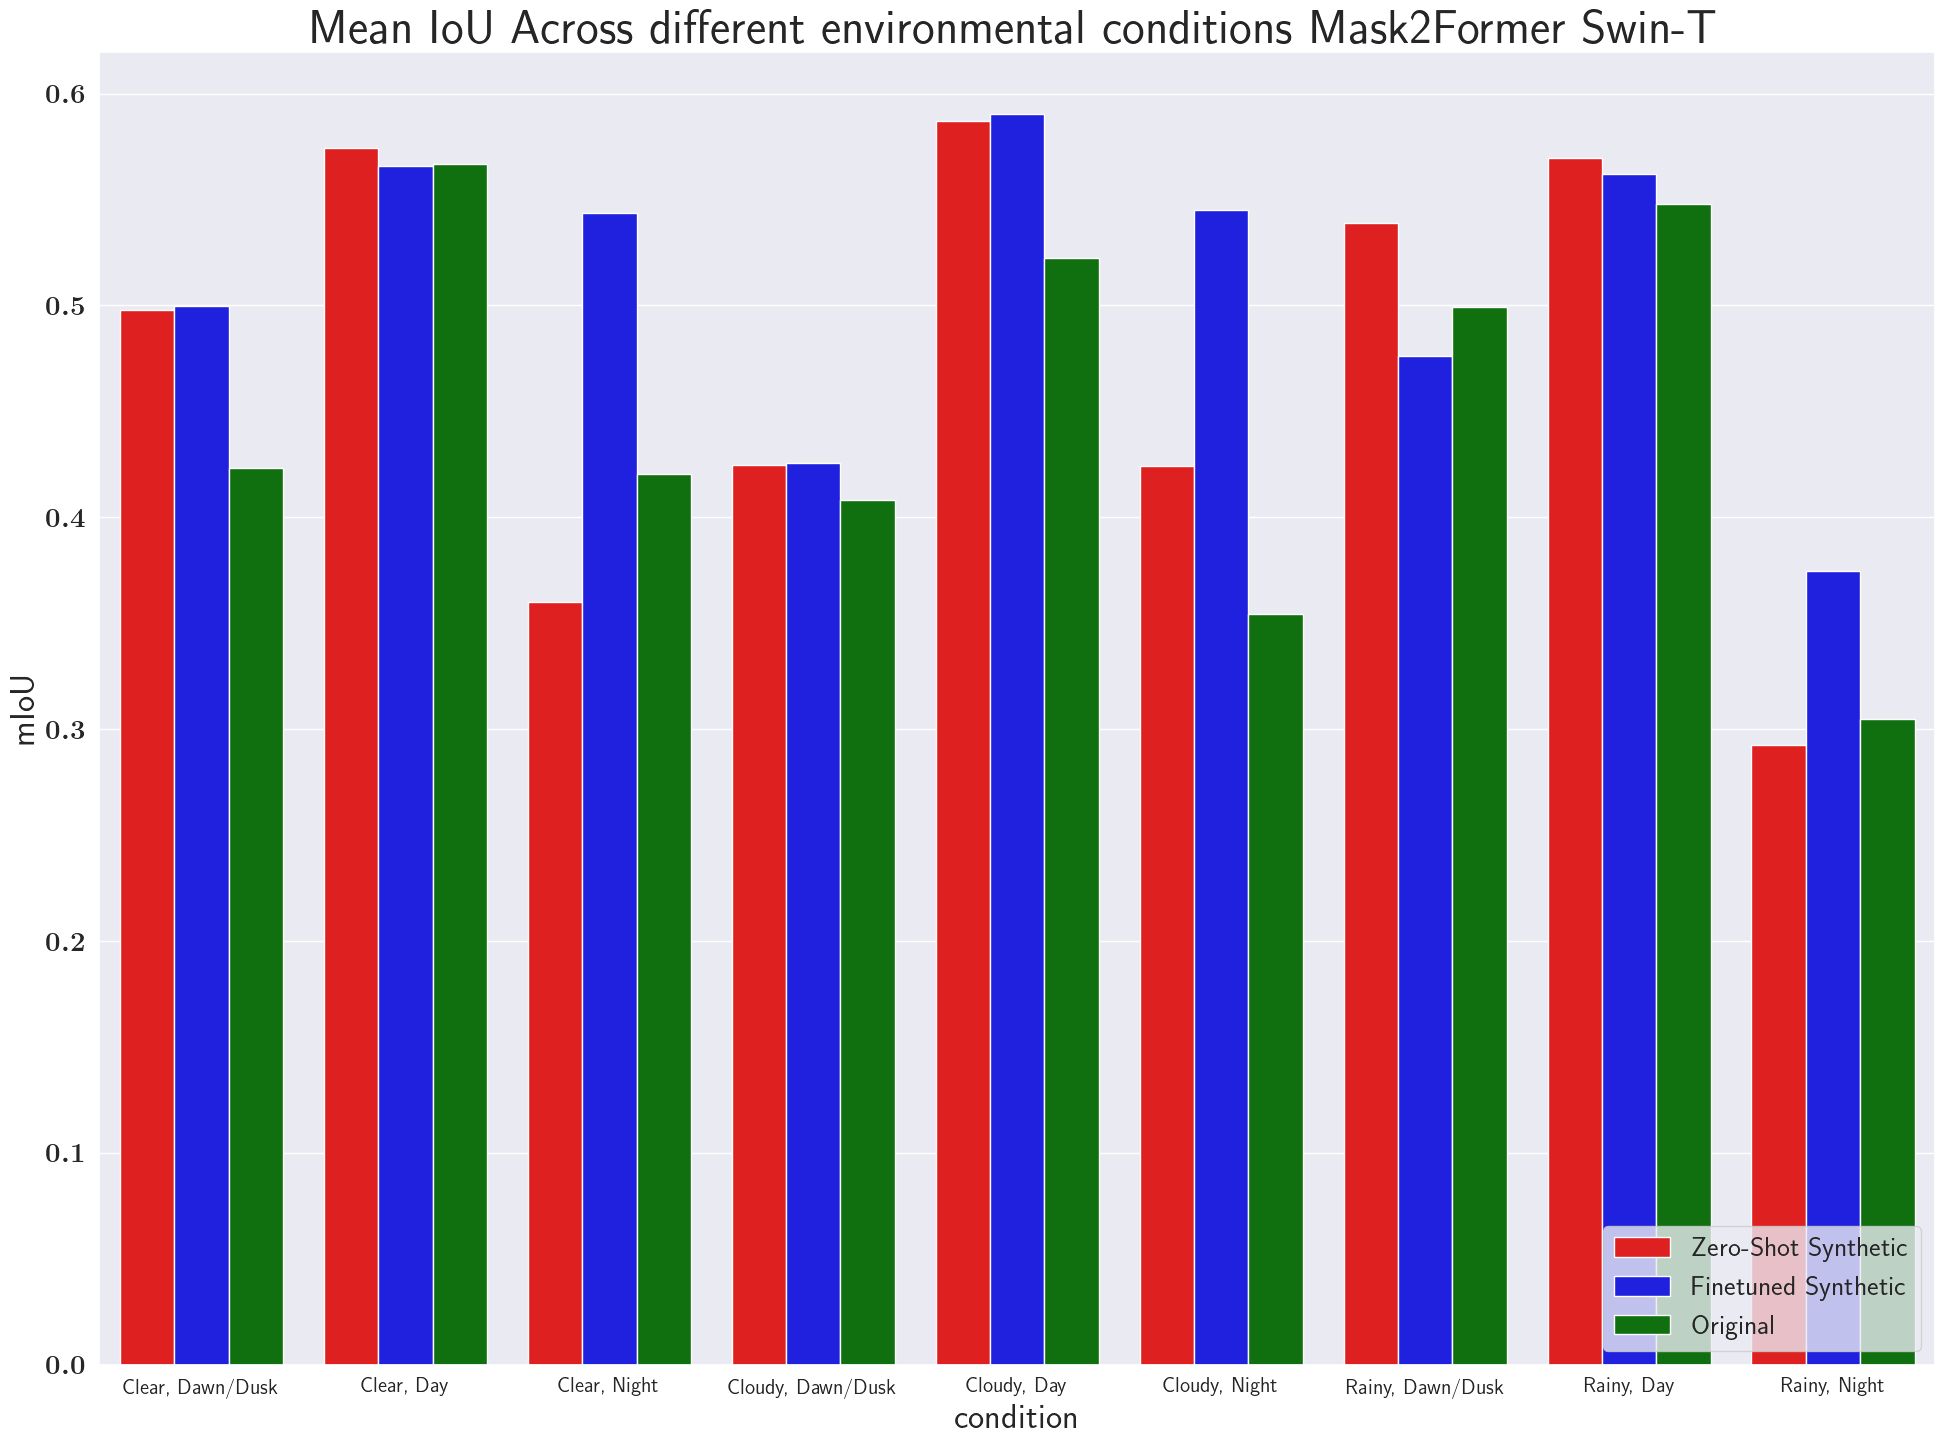

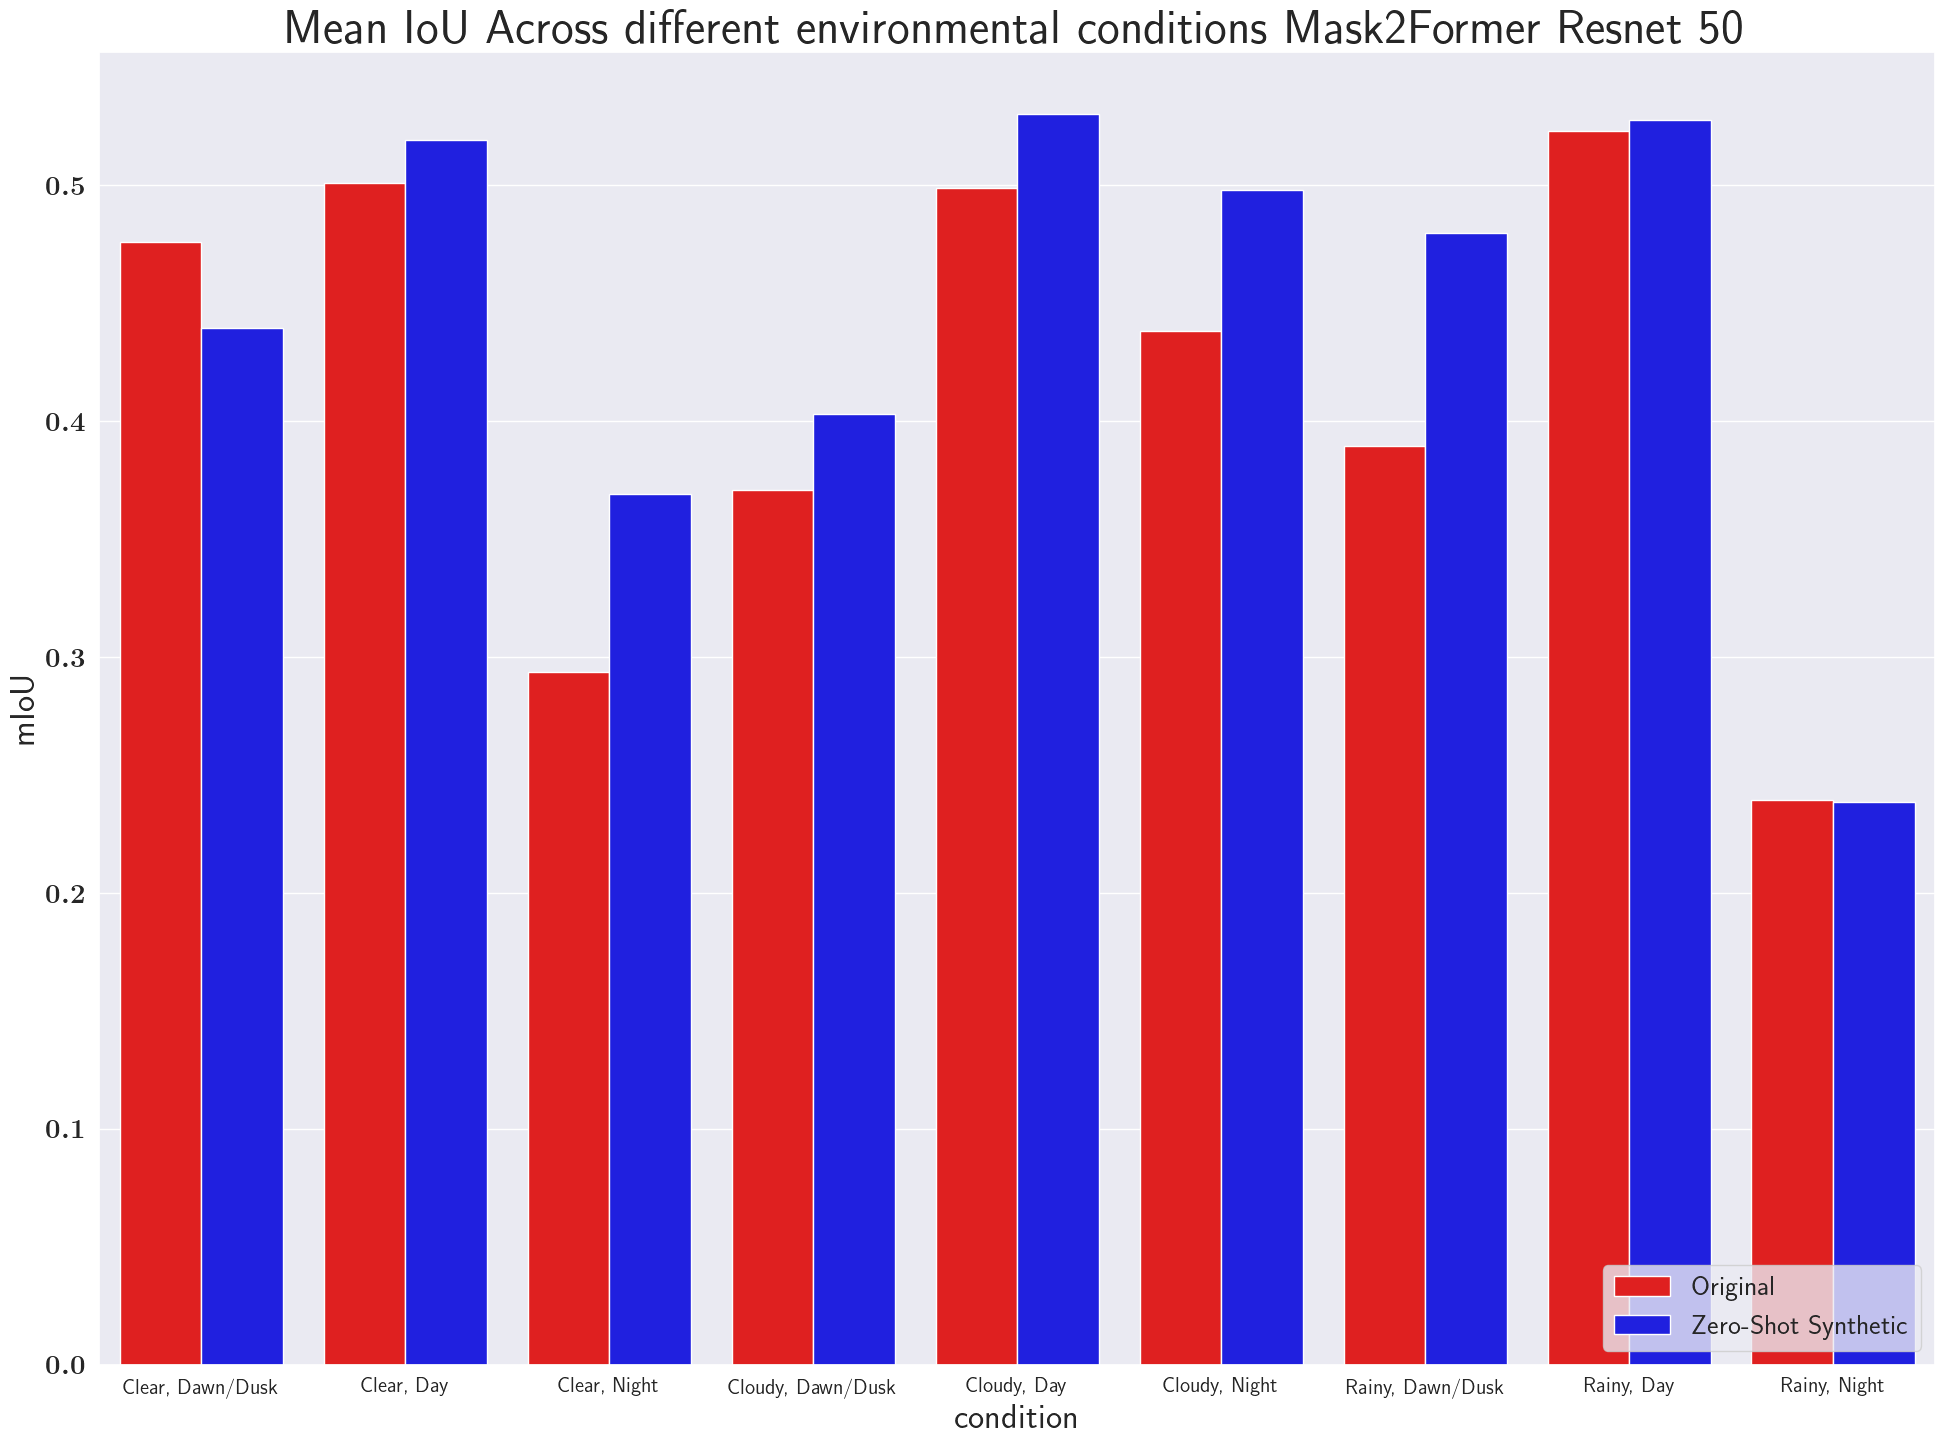

In [20]:
# Print the average metrics across all conditions

# Pretty Table for per class metrics
MDOELS = ['Mask2Former Swin-T', 'Mask2Former Resnet 50', 'Segformer']
metrics_column = ['mAcc','mIoU', 'mDice', 'mF1']
avg_metrics_table_data_dict = { k:PrettyTable() for k in MDOELS}
bar_plot_data = { k:[] for k in MDOELS}


for model, data_ in avg_data_plot.items():
    metrics = data_[metrics_column]
    model_cat = data_['model_cat'].unique()[0]
    
    if 'mixed' in model and 'ft' not in model:
        ret_metrics_cond = OrderedDict({
        ret_metric+'_mix': np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
        data_['ft_type'] = 'Zero-Shot Synthetic'
    elif 'ft' in model:
        ret_metrics_cond = OrderedDict({
        ret_metric+'_ft': np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
        data_['ft_type'] = 'Finetuned Synthetic'
    else:
        ret_metrics_cond = OrderedDict({
        ret_metric: np.round(ret_metric_value * 100, 2)
        for ret_metric, ret_metric_value in metrics.items()
         })
        data_['ft_type'] = 'Original'
    ret_metrics_cond.update({'Condition': list(data_['condition'])})
    ret_metrics_cond.move_to_end('Condition', last=False)

    avg_metrics_table_data_dict[model_cat].title = model_cat
    for key, val in ret_metrics_cond.items():
        avg_metrics_table_data_dict[model_cat].add_column(key, val)
    bar_plot_data[model_cat].append(data_)
    
for model, table in avg_metrics_table_data_dict.items():
    print(table)
    print('\n')


for model, tables in bar_plot_data.items():
    # Concatenate all the dataframes in tables
    table_data = pd.concat([dfs for dfs in tables], ignore_index=True)
    improvement_data = pd.DataFrame(columns=['condition', 'ft_type', 'mIoU', 'mAcc', 'mDice', 'mF1'])
    
    plt.figure(figsize=(20, 15))
    sns.barplot(table_data,
                    x='condition',
                    y='mIoU', 
                    hue='ft_type', 
                    palette=pallete[:3])
    plt.legend(fontsize=20, loc='lower right')
    plt.title('Mean IoU Across different environmental conditions {}'.format(model), fontsize=35)

    for cond in table_data['condition'].unique():
        sub_data = table_data[table_data['condition'] == cond]
        original = sub_data[sub_data['ft_type'] == 'Original']
        ft = sub_data[sub_data['ft_type'] == 'Finetuned Synthetic']
        mix = sub_data[sub_data['ft_type'] == 'Zero-Shot Synthetic']
        #print(original['mIoU'])
        #print((ft['mIoU'].values[0] - original['mIoU'].values[0])/original['mIoU'].values[0]*100)
        improvement_data = improvement_data.append({'condition': cond,
                                                    'ft_type': 'Finetuned Synthetic',
                                                    'mIoU': (ft['mIoU'].values[0] - original['mIoU'].values[0])/original['mIoU'].values[0]*100,
                                                    'mAcc': (ft['mAcc'].values[0] - original['mAcc'].values[0])/original['mAcc'].values[0]*100,
                                                    'mDice': (ft['mDice'].values[0] - original['mDice'].values[0])/original['mDice'].values[0]*100,
                                                    'mF1': (ft['mF1'].values[0] - original['mF1'].values[0])/original['mF1'].values[0]*100}, ignore_index=True)
        improvement_data = improvement_data.append({'condition': cond,
                                                    'ft_type': 'Zero-Shot Synthetic',
                                                    'mIoU': (mix['mIoU'].values[0] - original['mIoU'].values[0])/original['mIoU'].values[0]*100,
                                                    'mAcc': (mix['mAcc'].values[0] - original['mAcc'].values[0])/original['mAcc'].values[0]*100,
                                                    'mDice': (mix['mDice'].values[0] - original['mDice'].values[0])/original['mDice'].values[0]*100,
                                                    'mF1': (mix['mF1'].values[0] - original['mF1'].values[0])/original['mF1'].values[0]*100}, ignore_index=True)
        improvement_data = improvement_data.append({'condition': cond,
                                                    'ft_type': 'Original',
                                                    'mIoU': 0,
                                                    'mAcc': 0,
                                                    'mDice': 0,
                                                    'mF1': 0}, ignore_index=True)
    

    fig = px.line_polar(improvement_data, r='mIoU',
                        theta='condition',
                        color='ft_type',
                        line_close=True,
                        title='Mean IoU Improvement for {}'.format(model),
                        )
    fig.update_traces(fill='toself')
    fig.show()

## Plot performance of all trained models


In [ ]:
# Formatting data plot items
for model, data in data_plot.items():
    print(model)
    data['model'] = model
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)

    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    
    if 'synth' in model:
        data['dataset'] = 'Synthetic'
    elif 'mixed' in model and 'ft' not in model:
        data['dataset'] = 'Mixed'
    elif 'ft' in model:
        data['dataset'] = 'Fine-tuned Synthetic'
    else:
        data['dataset'] = 'Real'
    print(data.index)
    print(data.columns)
        
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data = pd.concat([dfs for dfs in data_plot.values()], ignore_index=True)
model_idxs = {'r50':[],'swin':[],'segformer':[]}

# store the indices of the models which contain the keys

for idx, model in enumerate(all_data['model']):
    if 'r50' in model:
        model_idxs['r50'].append(idx)
    elif 'swin' in model:
        model_idxs['swin'].append(idx)
    elif 'segformer' in model:
        model_idxs['segformer'].append(idx)
    else:
        print('Model not found')

mask2former_r50_8xb2-90k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
segformer_mit-b3_8xb2-160k_mixedbdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_swin-t_8xb2-160k_mixedbdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_r50_8xb2-90k_mixedbdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
segformer_mit-b3_8xb2-160k_bdd-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat',
       'dataset'],
      dtype='object')
mask2former_swin-t_8xb2-160k_bdd

Plots for model:  r50
     index                                      model         condition  \
0        0       mask2former_r50_8xb2-90k_bdd-512x512  Clear, Dawn/Dusk   
1        0       mask2former_r50_8xb2-90k_bdd-512x512  Clear, Dawn/Dusk   
2        0       mask2former_r50_8xb2-90k_bdd-512x512  Clear, Dawn/Dusk   
3        0       mask2former_r50_8xb2-90k_bdd-512x512  Clear, Dawn/Dusk   
4        0       mask2former_r50_8xb2-90k_bdd-512x512  Clear, Dawn/Dusk   
..     ...                                        ...               ...   
355     35  mask2former_r50_8xb2-90k_mixedbdd-512x512      Rainy, Night   
356     35  mask2former_r50_8xb2-90k_mixedbdd-512x512      Rainy, Night   
357     35  mask2former_r50_8xb2-90k_mixedbdd-512x512      Rainy, Night   
358     35  mask2former_r50_8xb2-90k_mixedbdd-512x512      Rainy, Night   
359     35  mask2former_r50_8xb2-90k_mixedbdd-512x512      Rainy, Night   

     accuracy dataset  
0    0.719695    Real  
1    0.964282    Real  
2    

/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(
/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(


Plots for model:  segformer
     index                                        model         condition  \
0        9  segformer_mit-b3_8xb2-160k_mixedbdd-512x512  Clear, Dawn/Dusk   
1        9  segformer_mit-b3_8xb2-160k_mixedbdd-512x512  Clear, Dawn/Dusk   
2        9  segformer_mit-b3_8xb2-160k_mixedbdd-512x512  Clear, Dawn/Dusk   
3        9  segformer_mit-b3_8xb2-160k_mixedbdd-512x512  Clear, Dawn/Dusk   
4        9  segformer_mit-b3_8xb2-160k_mixedbdd-512x512  Clear, Dawn/Dusk   
..     ...                                          ...               ...   
355     44       segformer_mit-b3_8xb2-160k_bdd-512x512      Rainy, Night   
356     44       segformer_mit-b3_8xb2-160k_bdd-512x512      Rainy, Night   
357     44       segformer_mit-b3_8xb2-160k_bdd-512x512      Rainy, Night   
358     44       segformer_mit-b3_8xb2-160k_bdd-512x512      Rainy, Night   
359     44       segformer_mit-b3_8xb2-160k_bdd-512x512      Rainy, Night   

     accuracy dataset  
0    0.680387   Mixed  

/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(


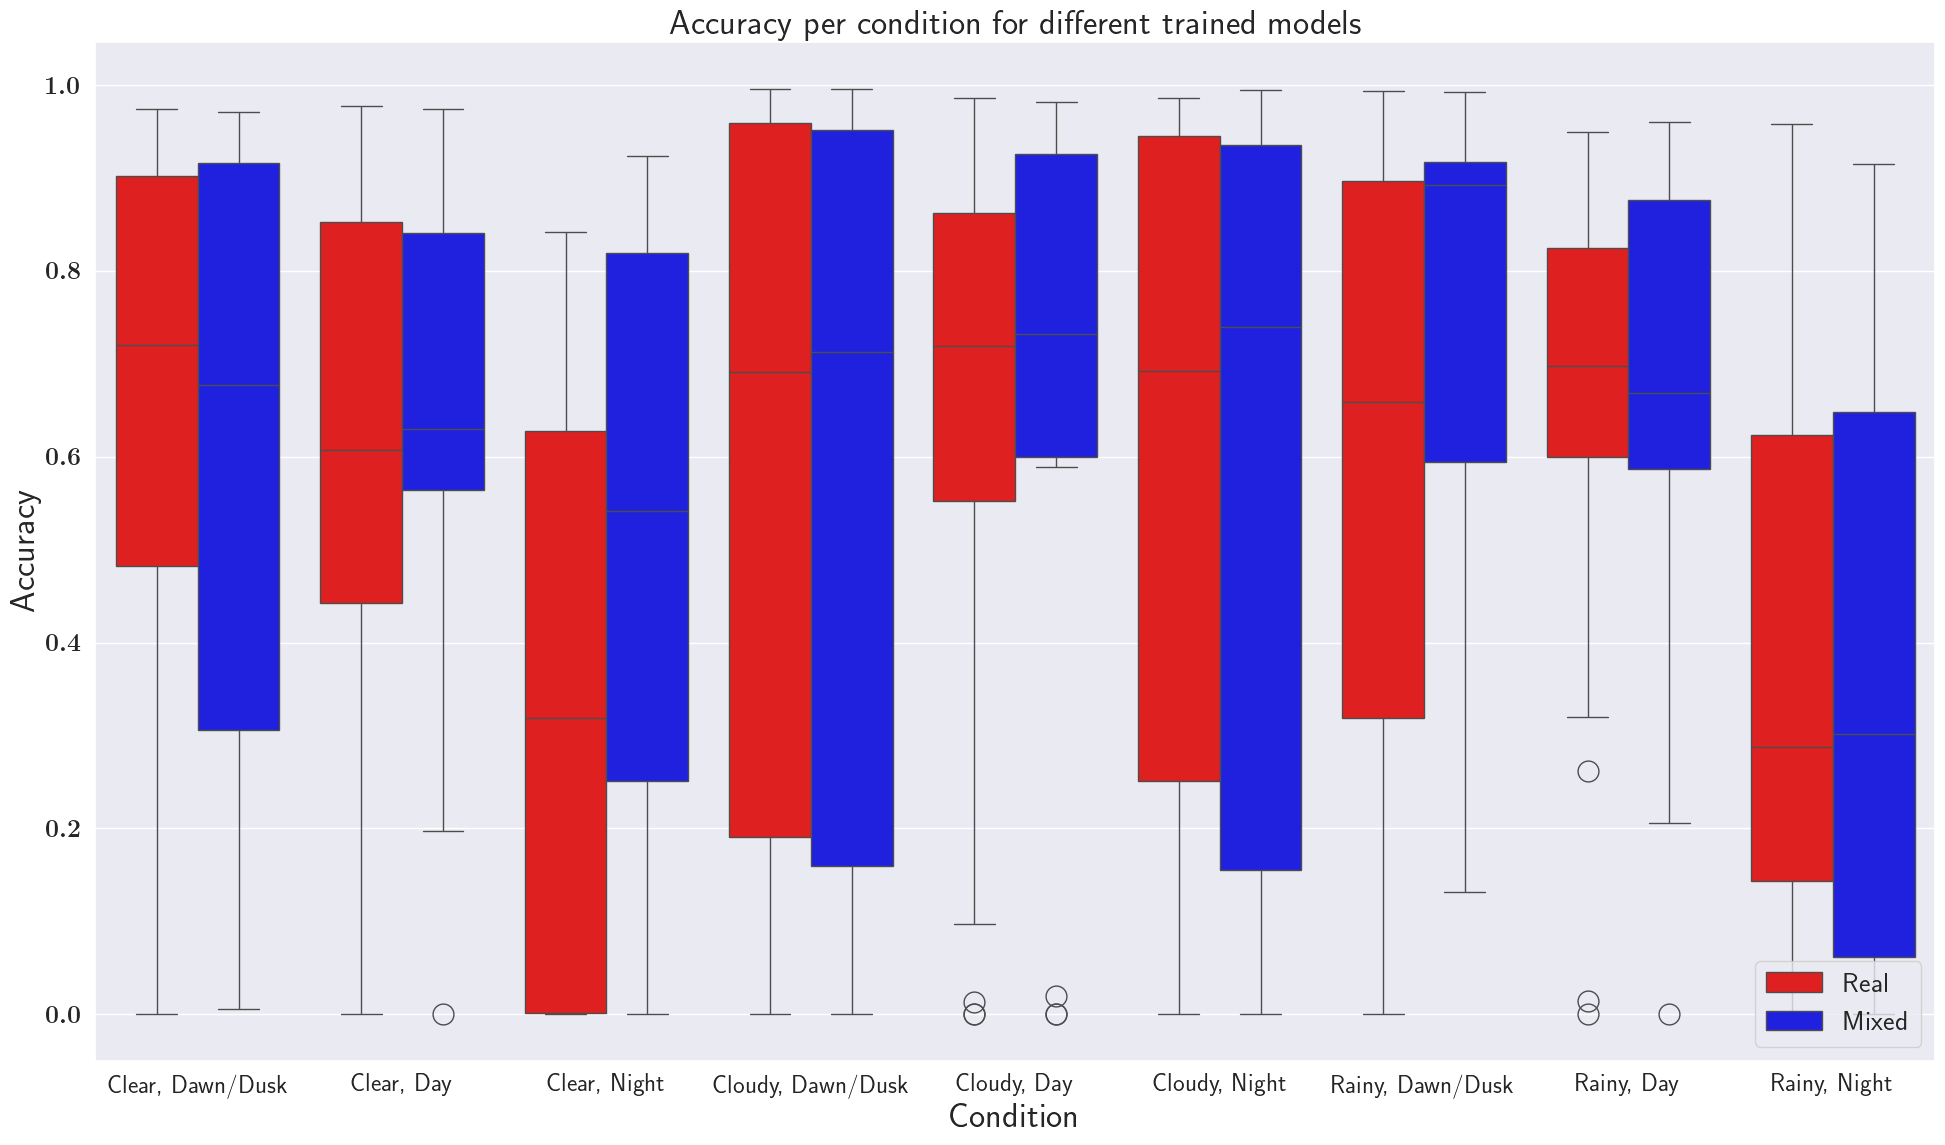

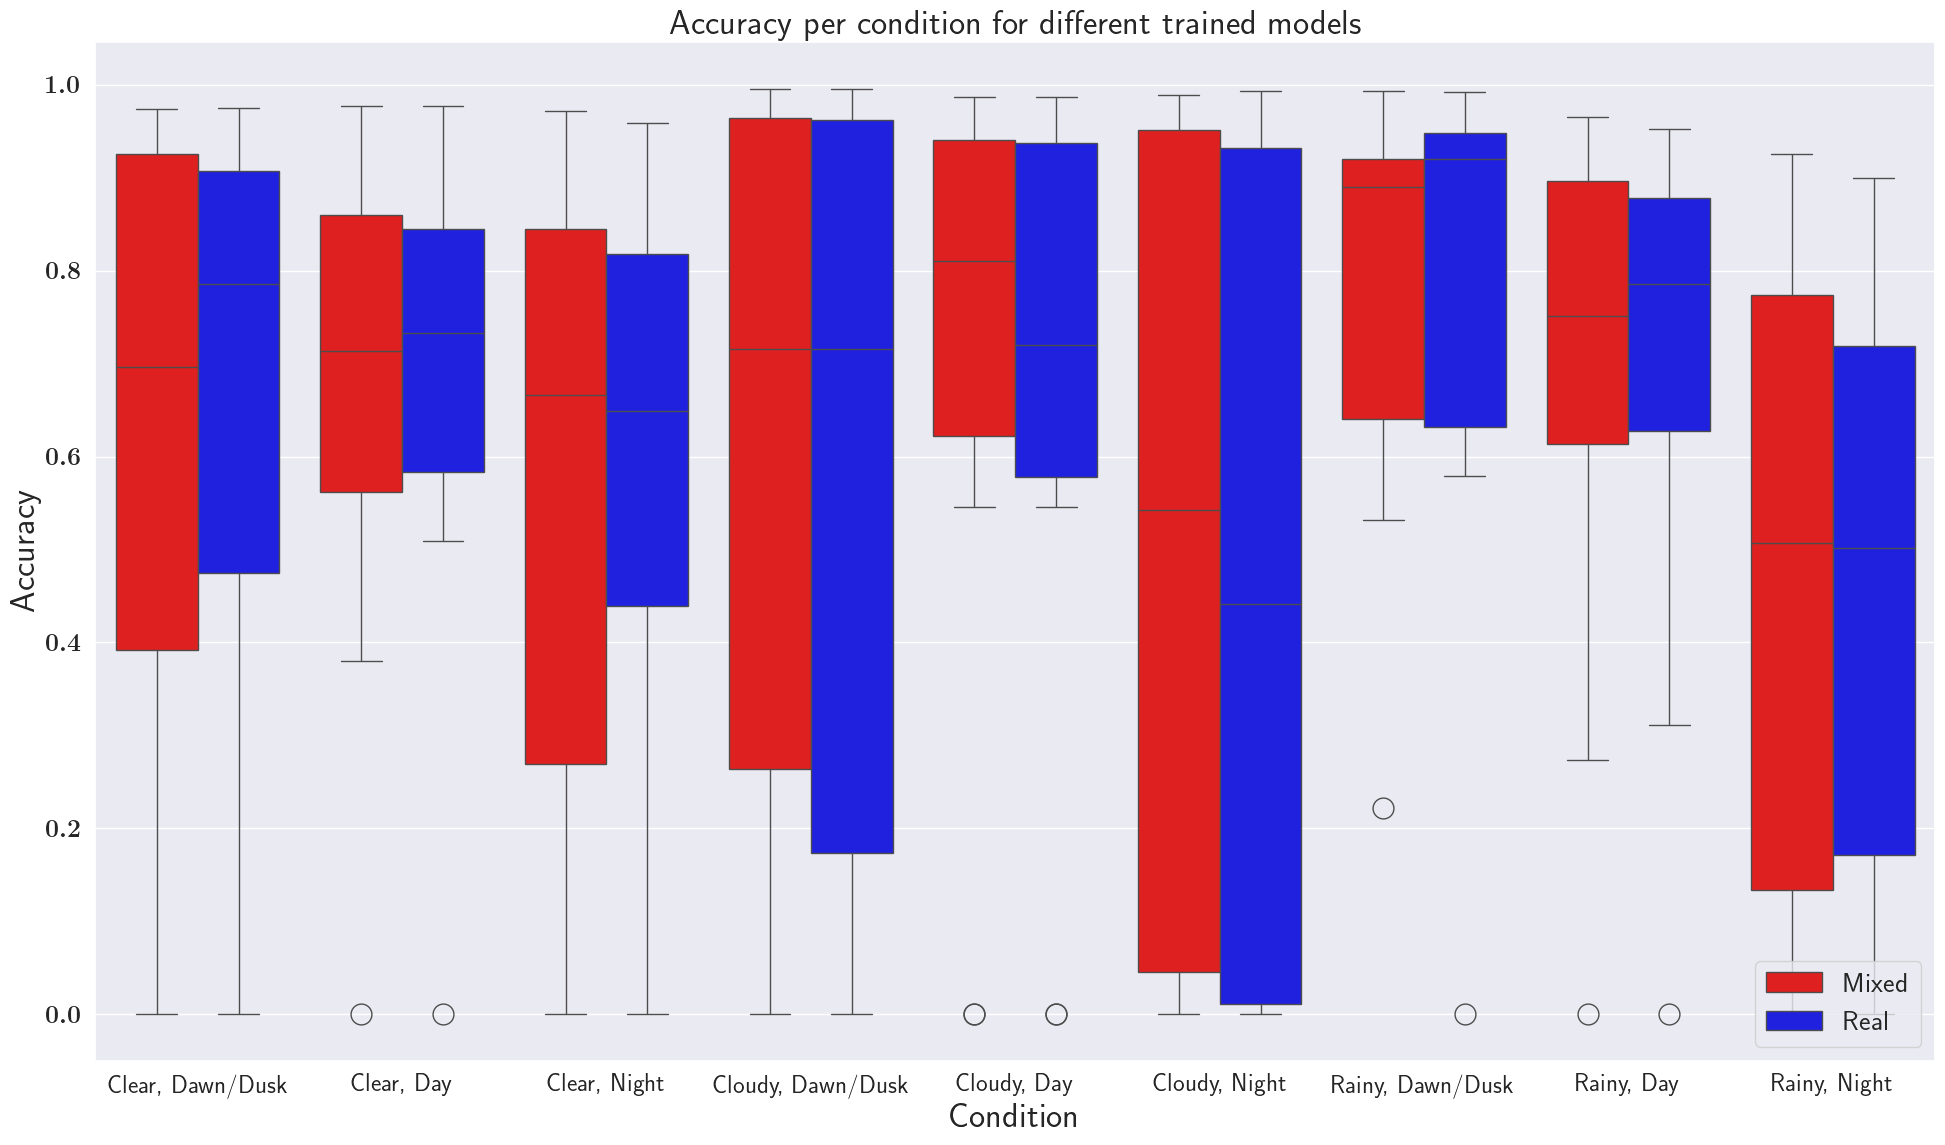

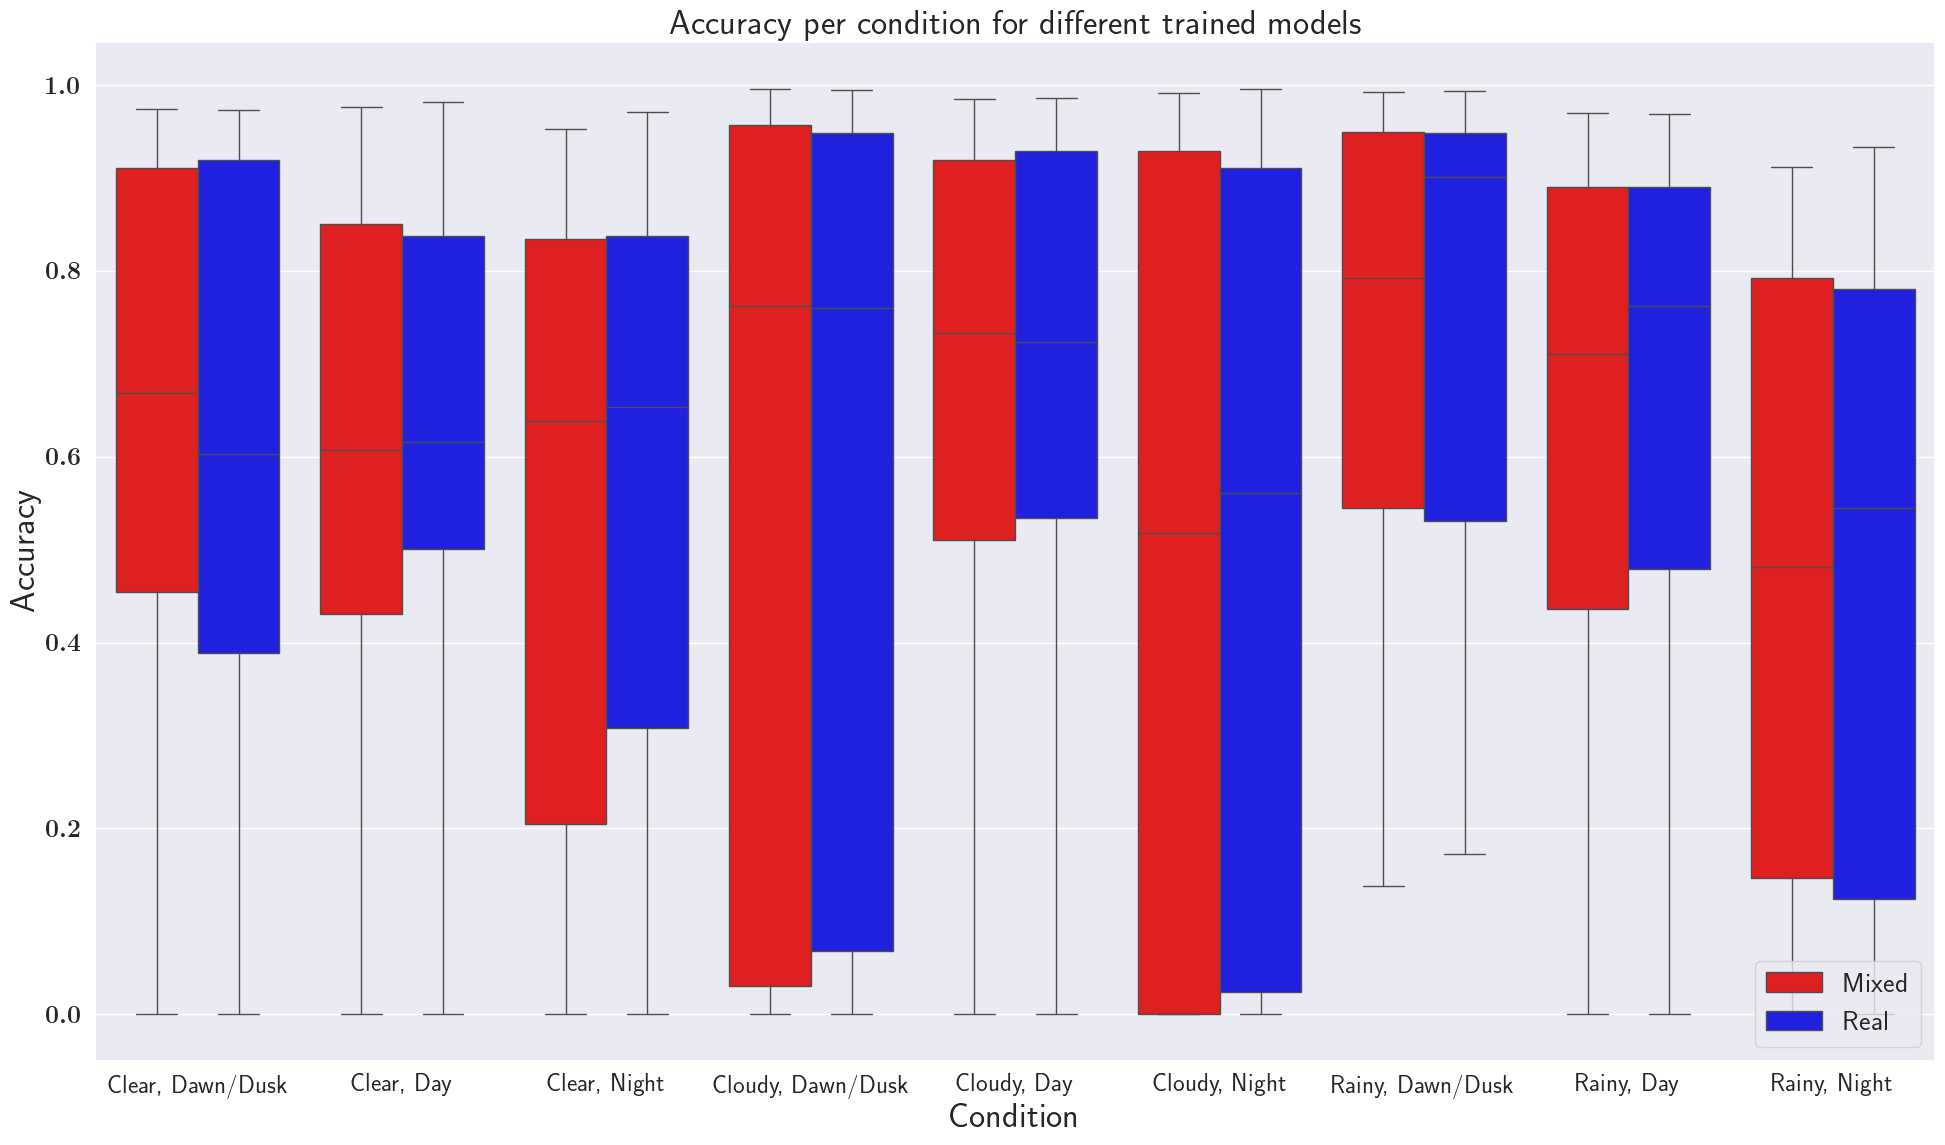

In [ ]:
# Plotting the results in a box plot
# Combine the dataframes into a single dataframe in data_plot

for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_acc = pd.DataFrame(columns=['model', 'condition', 'accuracy'])
    all_data_acc['model'] = all_data['model']
    all_data_acc['condition'] = all_data['condition']
    all_data_acc['accuracy'] = all_data['accuracy']
    all_data_acc['dataset'] = all_data['dataset']
    all_data_acc = all_data_acc.iloc[v]
    all_data_acc = all_data_acc.explode('accuracy').reset_index()

    print(all_data_acc)
    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_paired_boxplot(all_data_acc,
                        x_var='condition',
                        y_var='accuracy', 
                        hue='dataset', 
                        pal=pallete[:len(all_data_acc['condition'].unique())],
                        title_str = 'Accuracy per conditions',
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('Accuracy per condition for different trained models', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.xlabel('Condition', fontsize=25)


Plots for model:  r50
Plots for model:  swin
Plots for model:  segformer


/tmp/ipykernel_1186873/2574205518.py:35: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,
/tmp/ipykernel_1186873/2574205518.py:35: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,
/tmp/ipykernel_1186873/2574205518.py:35: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,


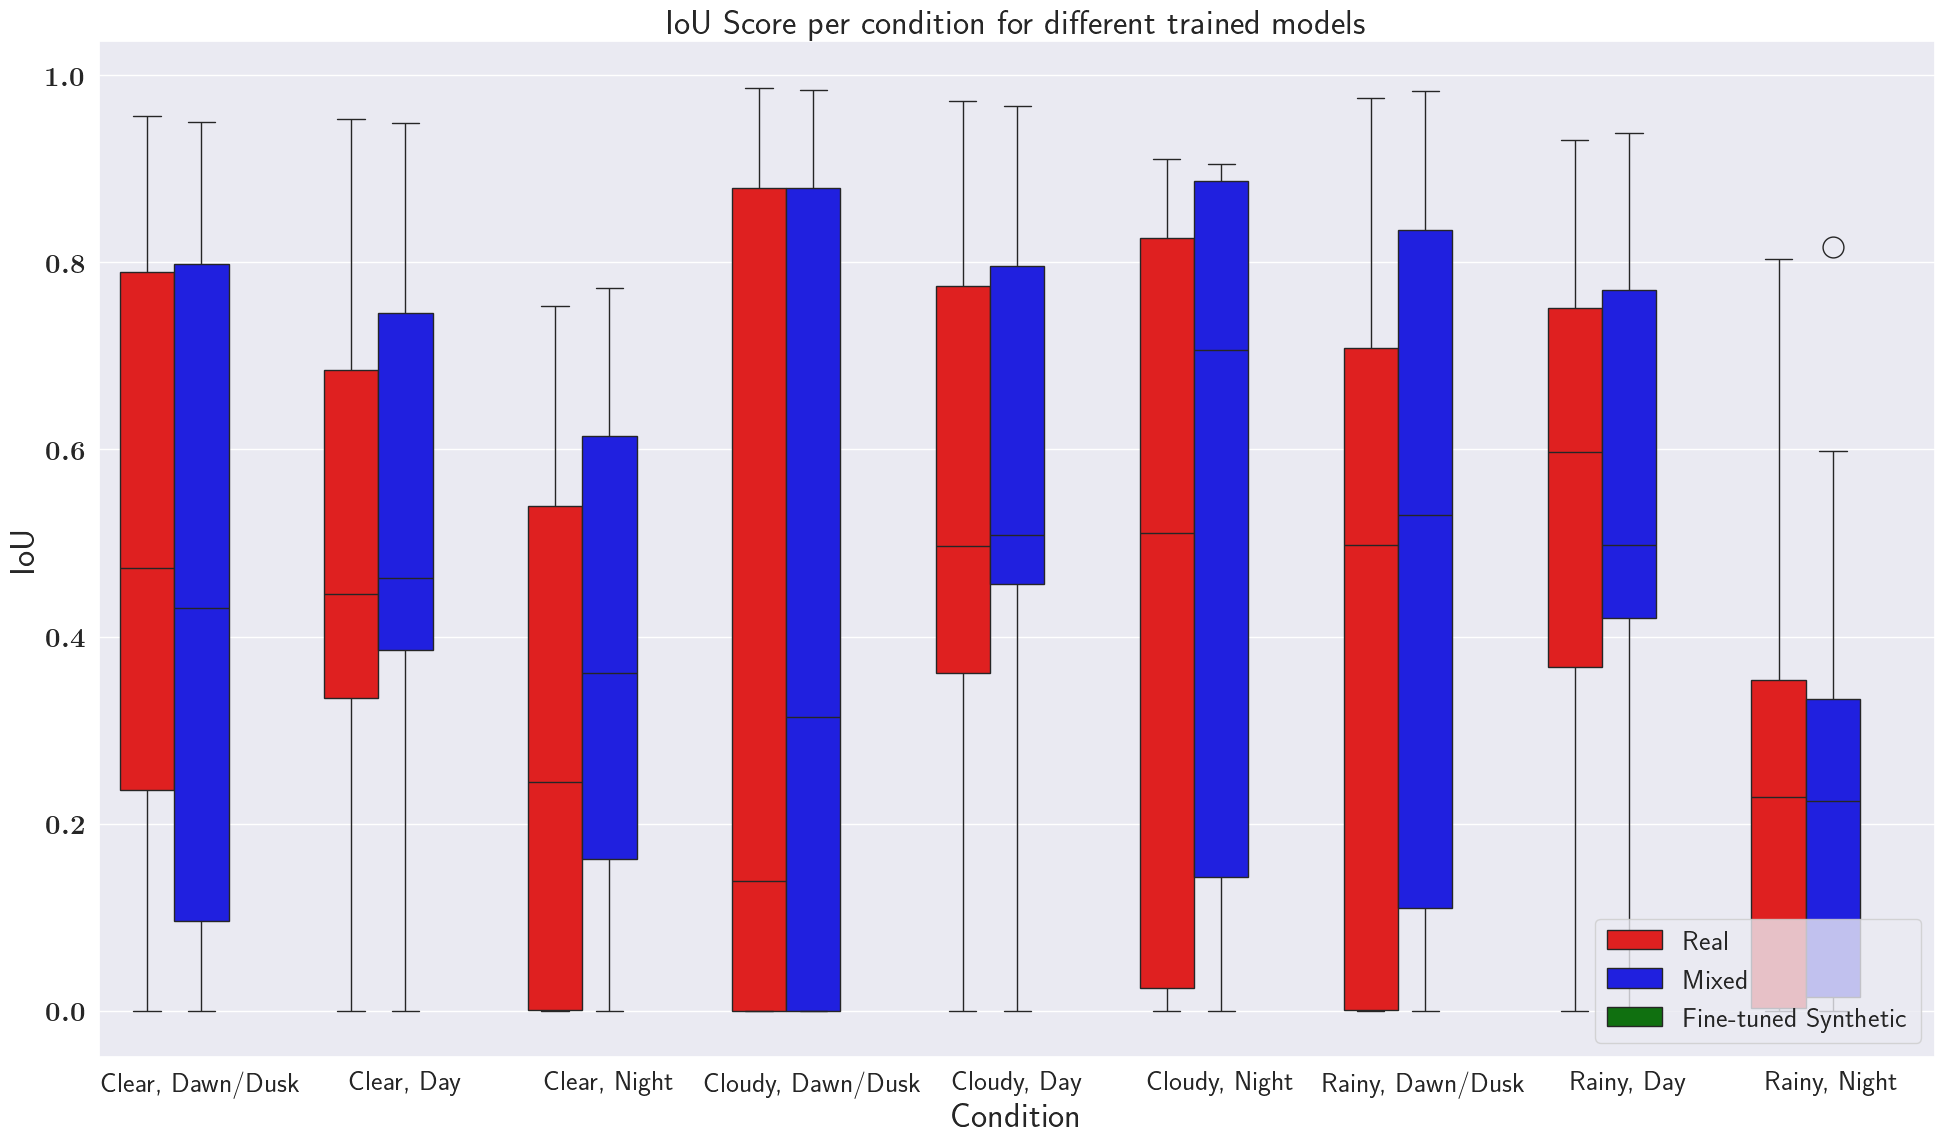

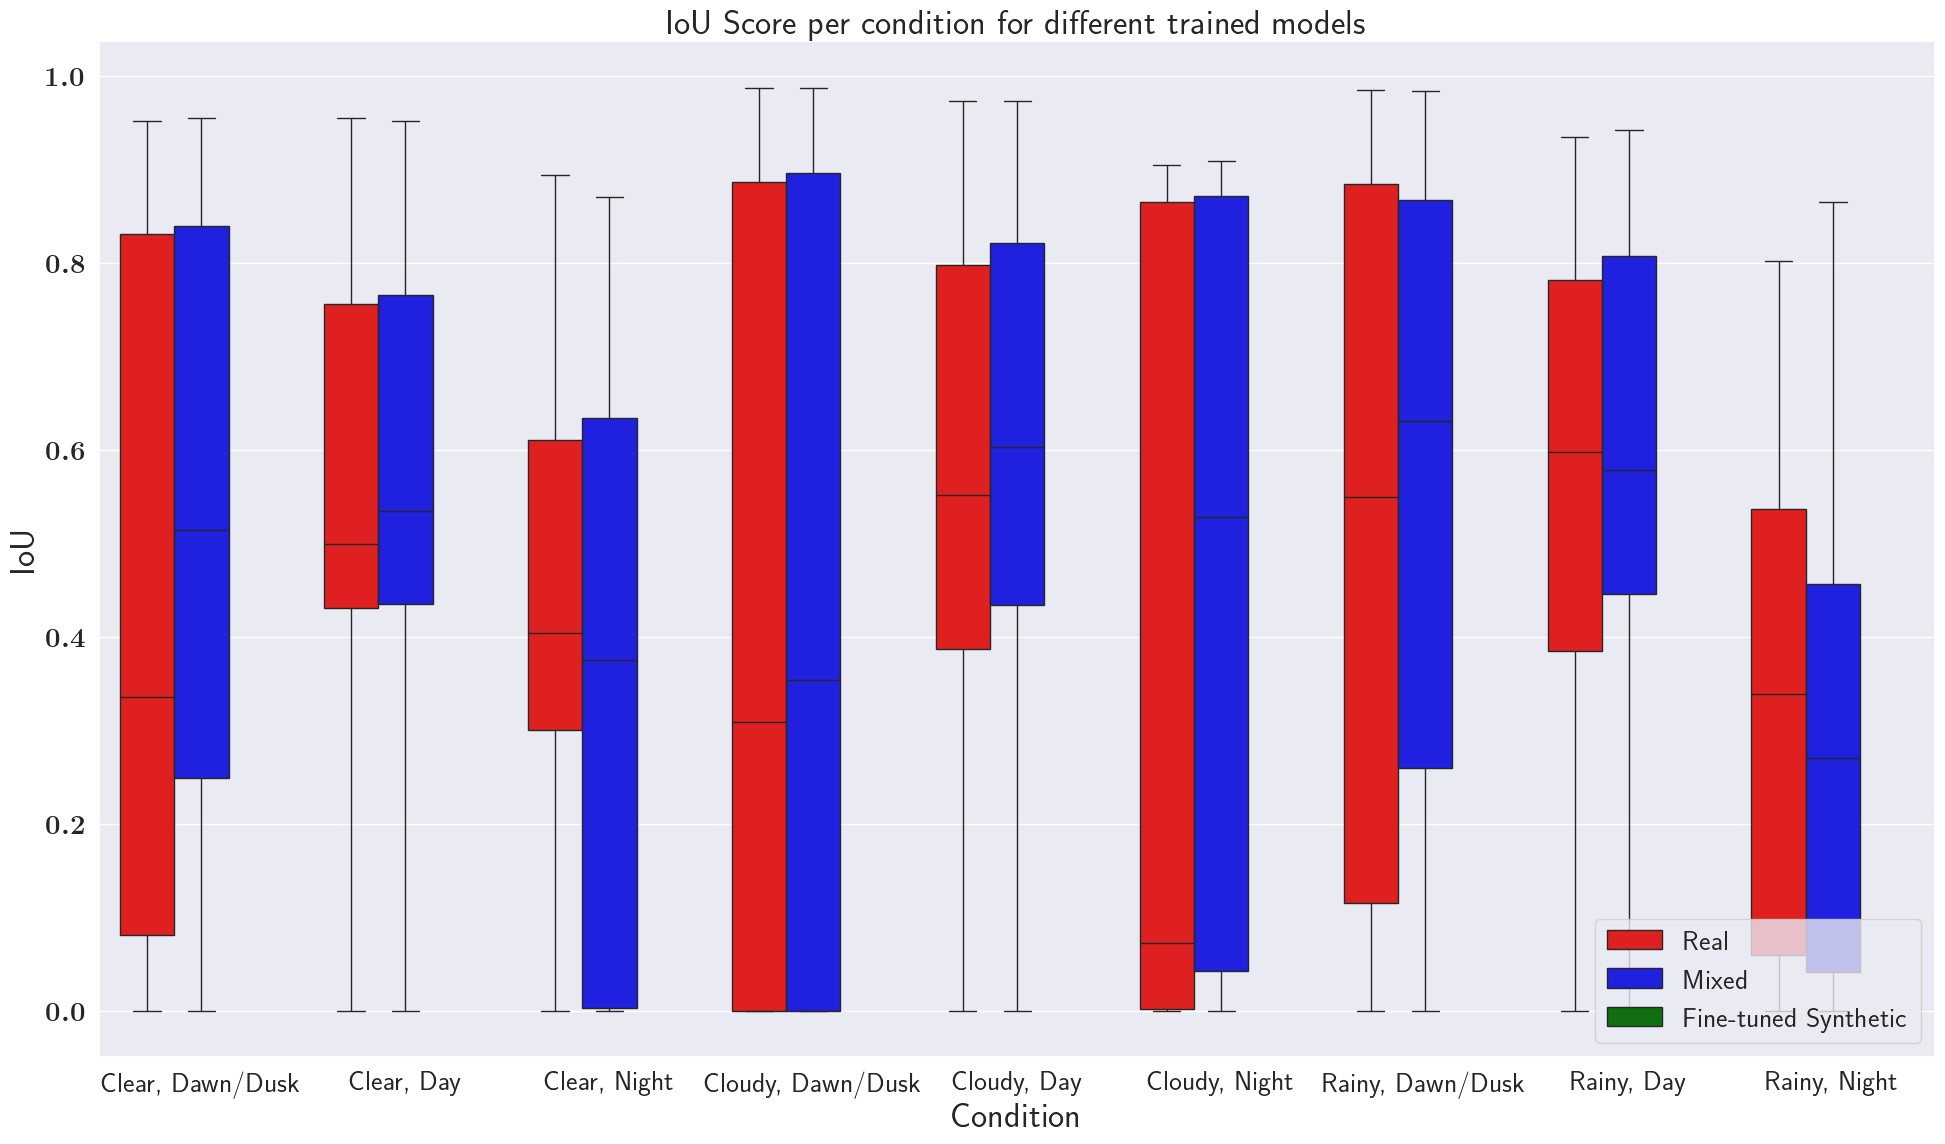

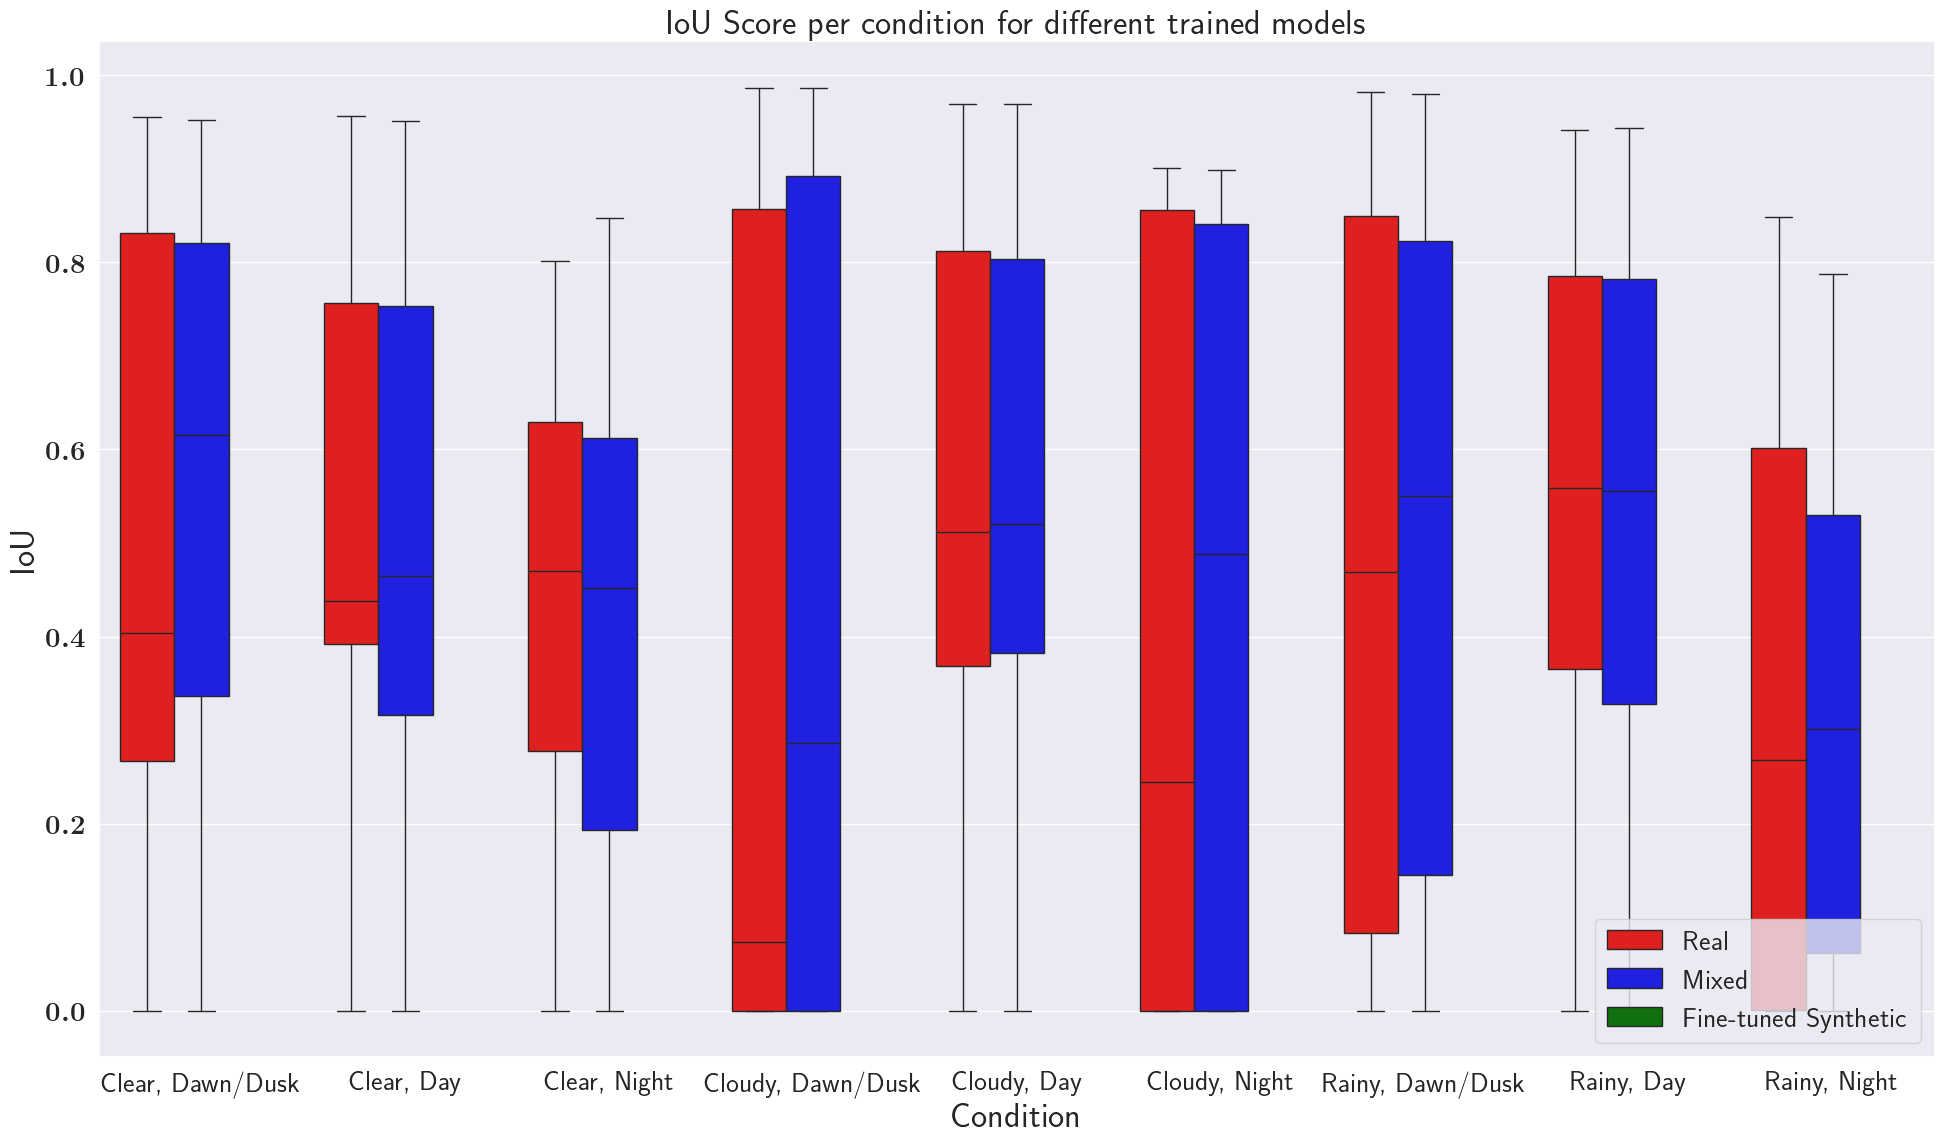

In [ ]:
order = ['Real','Mixed','Fine-tuned Synthetic']
for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_iou = pd.DataFrame(columns=['model', 'condition', 'IoU'])
    all_data_iou['model'] = all_data['model']
    all_data_iou['condition'] = all_data['condition']
    all_data_iou['IoU'] = all_data['IoU']
    all_data_iou['dataset'] = all_data['dataset']
    all_data_iou = all_data_iou.iloc[v]

    all_models = list(all_data_iou['model'].unique())
    
    hue_order = []
    j=0
    # sort by order
    # for i in order:
    #     for model in all_models:
    #         if i in model:
    #             hue_order.append(model)
    #             all_models.remove(model)
    hue_order = order
    #print(all_data_iou)
    all_data_iou = all_data_iou.explode('IoU').reset_index()

    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.boxplot(all_data_iou,
                        x='condition',
                        y='IoU', 
                        hue='dataset', 
                        palette=pallete[:len(all_data_iou['condition'].unique())],
                        hue_order=hue_order,
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('IoU Score per condition for different trained models', fontsize=25)
    plt.ylabel('IoU', fontsize=25)
    plt.xlabel('Condition', fontsize=25)



all_data_dice = pd.DataFrame(columns=['model', 'condition', 'Dice'])
all_data_dice['model'] = all_data['model']
all_data_dice['condition'] = all_data['condition']
all_data_dice['Dice'] = all_data['Dice']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='Dice', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


ValueError: Could not interpret value `F1` for `y`. An entry with this name does not appear in `data`.

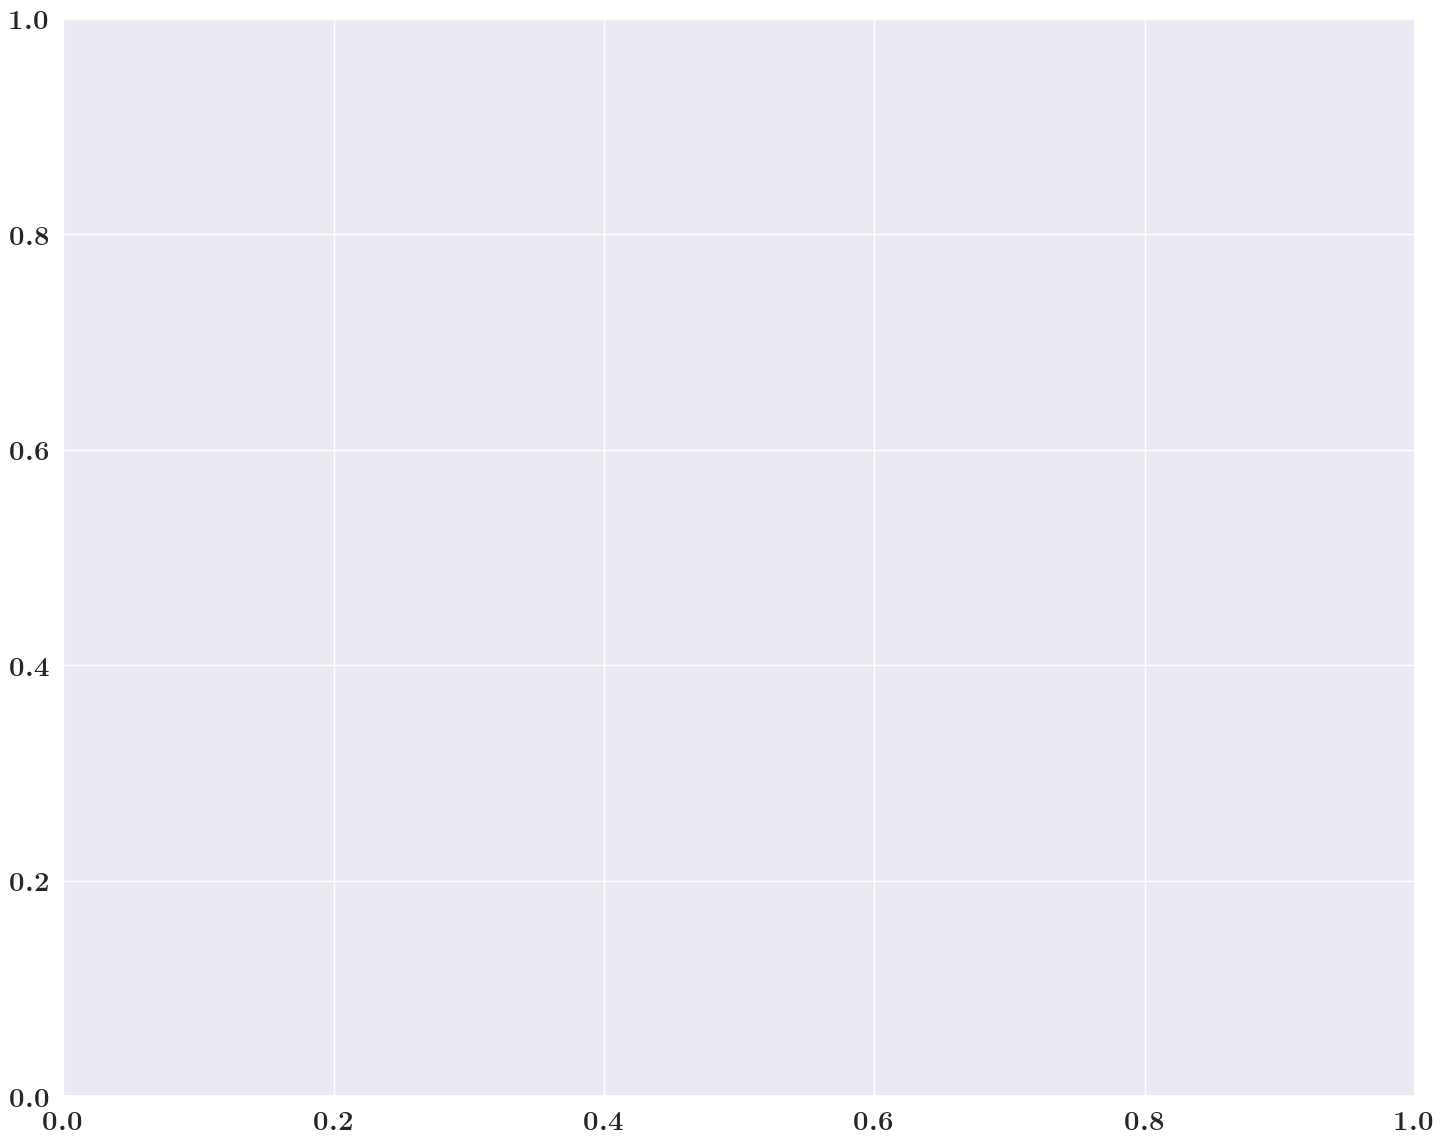

In [ ]:
all_data_f1 = pd.DataFrame(columns=['model', 'condition', 'F1'])
all_data_f1['model'] = all_data['model']
all_data_f1['condition'] = all_data['condition']
all_data_f1['F1'] = all_data['F1']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='F1', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)
